#**Automatic cyberbullying detection**
##Imbalanced text classification: classifying harmful tweets in Polish

PolEval 2019 Task 6: **Automatic cyberbullying detection**
http://2019.poleval.pl/index.php/tasks/task6

With rapid grew in popularity of Social Networking Services, cyberbullying is becoming a problem affecting more and more people. Anonymity allows Internet users to post offensive and inappropriate comments while hiding behind a pseudonym.

To deal with this problem on a large scale, automated methods are needed to detect texts containing cyberbullying. Much in the area of ​​this research has been done for popular languages ​​such as English.

The aim of the task is to automatically classify tweets containing harmful content in Polish.

##Necessary imports

###**worked with legacy API in torchtext**



In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from torchtext.legacy import data, vocab

import torch
import torch.nn as nn

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch import nn
from torch.optim import SGD, Adam
from torch.nn.functional import cross_entropy

import gensim
from gensim.models import Word2Vec, KeyedVectors, word2vec

In [ ]:
#function for ploting model training history
def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}% (train: {:.2f}%)".format(
                max(h['test_accuracy']) * 100,
                max(h['train_accuracy']) * 100
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['train_accuracy'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

        if len(histories) == 1:
            ax[1].set_title("Minimal train loss: {:.4f} (test: {:.4f})".format(
                min(h['train_loss']),
                min(h['test_loss'])
            ))
        else:
            ax[1].set_title("Loss")
        ax[1].plot(h['train_loss'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(h['test_loss'], color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        if loss_top:
            ax[1].set_ylim(top=loss_top)
        ax[1].legend()

    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

##Data
Training and test data consit of **tweets** and **tags** - 



normal/non-harmful tweets (**class: 0**) and tweets that contain any kind of harmful information (**class: 1**)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###TRAIN DATA

In [ ]:
# training data

#/content/test_data.csv
path = '/content/drive/MyDrive/Sulikowska_aann_project/'
train_text = path + 'task_6-1/training_set_clean_only_text.txt'
train_tags = path + 'task_6-1/training_set_clean_only_tags.txt'

In [ ]:
df_tags = pd.read_csv(train_tags, delimiter = "\t", header=None, names=['tag'], encoding= 'utf8')
df_tweets = pd.read_csv(train_text, delimiter = "\t", header=None, names=['tweet'], encoding= 'utf8')
df = pd.concat([df_tags, df_tweets], axis=1)
df.head()

,tag,tweet
0,0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,0,@anonymized_account @anonymized_account Brawo ...
2,0,"@anonymized_account @anonymized_account Super,..."
3,0,@anonymized_account @anonymized_account Musi. ...
4,0,"Odrzut natychmiastowy, kwaśna mina, mam problem"


###TEST DATA

In [ ]:
# test data
test_text = path + 'task 01/test_set_clean_only_text.txt'
test_tags = path + 'task 01/test_set_clean_only_tags.txt'

In [ ]:
df_tags_ = pd.read_csv(test_tags, delimiter = "\t", header=None, names=['tag'], encoding= 'utf8')
df_tweets_ = pd.read_csv(test_text, delimiter = "\t", header=None, names=['tweet'], encoding= 'utf8')
df_ = pd.concat([df_tags_, df_tweets_], axis=1)
df_.head()

,tag,tweet
0,0,"@anonymized_account Spoko, jak im Duda z Moraw..."
1,0,@anonymized_account @anonymized_account Ale on...
2,0,@anonymized_account No czy Prezes nie miał rac...
3,0,@anonymized_account @anonymized_account Przeci...
4,0,@anonymized_account @anonymized_account Owszem...


##Data exploration

Most common words in harmful and non-harmful tweets.

In [ ]:
df_0 = df[df['tag']==0]
df_1 = df[df['tag']==1]

**Non-harmful tweets**

In [ ]:
top = pd.DataFrame(Counter(" ".join(df_0["tweet"]).split()).most_common(20))
top.columns = ['Common_words', 'Count']
top

,Common_words,Count
0,@anonymized_account,12319
1,nie,2354
2,to,2339
3,w,2066
4,na,1774
5,i,1639
6,się,1573
7,z,1470
8,że,1193
9,do,841


**Harmful tweets**

In [ ]:
top = pd.DataFrame(Counter(" ".join(df_1["tweet"]).split()).most_common(20))
top.columns = ['Common_words', 'Count']
top

,Common_words,Count
0,@anonymized_account,1413
1,nie,224
2,to,200
3,w,193
4,i,176
5,z,154
6,na,139
7,się,126
8,jak,99
9,RT,95


The collection includes **9190** texts marked as neutral and **851** texts whose content contains cyberbullying.

In [ ]:
x = df['tag'].value_counts()
x

0    9190
1     851
Name: tag, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


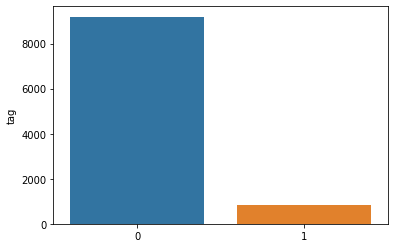

In [ ]:
num_zeros = x[0]
num_ones = x[1]
total = num_zeros + num_ones
sns.barplot(x.index,x)

In [ ]:
df_per=df.groupby('tag')['tweet'].count().rename("percentage").transform(lambda x: x/x.sum())

df_per.reset_index()

,tag,percentage
0,0,0.915247
1,1,0.084753


It is highly imbalanced dataset. We have **92%** of non-cyberbullying tweets (class: 0) and **8%** of offensive tweets (class: 1).

#Data preprocessing

From texts of tweets I decided to remove **mentions**, **hashtags**, **URLs**,  **punctuation** and finally also **lowercase** all the letters. 

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'@[\w]*', '')
df['tweet'] = df['tweet'].str.replace(r'@[A-Za-z0-9]+', '') #removing mentions
df['tweet'] = df['tweet'].str.replace(r'#[A-Za-z0-9]+', '') #removing hashtags
df['tweet'] = df['tweet'].str.replace(r'\w+:\/\/\S+', '') #removing URLs
df['tweet'] = df['tweet'].str.replace(r'[\.\,\!\?\:\;\-\=\_]', '') #removing punctuation
df['tweet'] = df['tweet'].str.lower() #lower case
df.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df = df[df['tweet'].notna()]

df_['tweet'] = df_['tweet'].str.replace(r'@[\w]*', '')
df_['tweet'] = df_['tweet'].str.replace(r'@[A-Za-z0-9]+', '') #removing mentions
df_['tweet'] = df_['tweet'].str.replace(r'#[A-Za-z0-9]+', '') #removing hashtags
df_['tweet'] = df_['tweet'].str.replace(r'\w+:\/\/\S+', '') #removing URLs
df_['tweet'] = df_['tweet'].str.replace(r'[\.\,\!\?\:\;\-\=\_]', '') #removing punctuation
df_['tweet'] = df_['tweet'].str.lower() #lower case
df_.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_ = df_[df_['tweet'].notna()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist

In [ ]:
#writing cleaned data to csv files
df.to_csv('train_data.csv') 
df_.to_csv('test_data.csv') 

Polish word embeddings trained on **Wikipedia** and **NKJP**
http://dsmodels.nlp.ipipan.waw.pl/

Now we have word meanings represented by 100 dimensional vectors.

###Pretrained embeddings

In [ ]:
#embeddings
nkjp = path + 'nkjp+wiki-forms-all-100-cbow-hs.txt.gz'

###Tokenization of texts

In [ ]:
TEXT = data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = data.LabelField( batch_first=True)

fields = {'tag': ('tag', LABEL), 'tweet': ('tweet', TEXT)}

train_data = data.TabularDataset(
                            path = '/content/train_data.csv',
                            format = 'csv', 
                            fields = fields
)
test_data = data.TabularDataset(
                            path = '/content/test_data.csv',
                            format = 'csv', 
                            fields = fields
)
print(vars(train_data[5]))

{'tag': '0', 'tweet': ['jaki', 'on', 'był', 'fajny', 'xdd', 'pamiętam', 'że', 'spóźniłam', 'się', 'na', 'jego', 'pierwsze', 'zajęcia', 'i', 'to', 'sporo', 'i', 'za', 'karę', 'kazał', 'mi', 'usiąść', 'w', 'pierwszej', 'ławce', 'xd']}


###Building vocabulary based on pretrained embeddings.

In [ ]:
Vectors = vocab.Vectors (name = nkjp) 

TEXT.build_vocab(train_data, min_freq=3, vectors = Vectors)  
LABEL.build_vocab(train_data)


#unique tokens in text
print("Size of TEXT vocabulary:", len(TEXT.vocab))

#unique tokens in label
print("Size of LABEL vocabulary:", len(LABEL.vocab))

#most common words
print(TEXT.vocab.freqs.most_common(10))  

100%|██████████| 2123132/2123132 [01:42<00:00, 20690.59it/s]


Size of TEXT vocabulary: 4989
Size of LABEL vocabulary: 2
[(' ', 6451), ('nie', 3093), ('to', 2964), ('w', 2513), ('  ', 2248), ('i', 2134), ('na', 2078), ('się', 1790), ('z', 1762), ('a', 1346)]


###Preparing batches for training the model.

In [ ]:
batch_size = 32
train_iter = data.BucketIterator(train_data, sort_key = lambda x: len(x.tweet), sort_within_batch=True, batch_size = batch_size, device = device)
test_iter = data.BucketIterator(test_data, sort_key = lambda x: len(x.tweet), sort_within_batch=True, batch_size = batch_size, device = device)

###Model architecture

**Embedding layer**: each row (number of rows - **number of unique words** in a vocabulary) represents an embedding of a word (**100 dimensions** for representing each word)

**LSTM layer**: capable of capturing long term dependencies

**Linear layer**

**Sigmoid** activation function

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        

        embedded = self.embedding(text)

        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        dense_outputs=self.fc(hidden)

        #activation function
        outputs=self.act(dense_outputs)
        
        return outputs

###Hyperparameters
**number of epochs**: 120

**batch size**: 32

**number of hidden nodes**: 32

**number of layers stacked in LSTM layer**: 3

**Dropout layer on the outputs of each LSTM layer**: 0.2

**bidirectional LSTM**

**number of classes**: 2

**learning rate**: 0.01

To handle class imbalance I applied class weighting. For **class 0** it is **weight equal to 1** and for **class 1** weight is equal to **number of zeros** divided by **number of ones**.

In [ ]:
#defining hyperparameters
n_epochs: int = 120
vocab_size = len(TEXT.vocab)
embed_dim = 100
num_hidden = 32
num_output = 2
num_layers = 3
bidirection = True
dropout = 0.2
lr: float = 0.01


#initialize the model
model = Classifier(vocab_size, embed_dim, num_hidden, num_output, num_layers, 
                   bidirectional = True, dropout = dropout)
model = model.to(device)
#optimizer
optimizer: torch.optim.Optimizer = Adam(model.parameters(), lr=lr)

#class weights
weight = torch.tensor([num_zeros/num_zeros, num_zeros/num_ones]).float()
criterion = nn.CrossEntropyLoss(weight=weight)
criterion = criterion.to(device)

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

#pretrained embeddings
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

# training loop

for e in range(n_epochs):

    train_iter.create_batches()
    test_iter.create_batches()
    correct: int = 0 
    numel: int = 0

    for i, batch in enumerate(train_iter):

        tag = batch.tag.long() 
        tweet, len_text = batch.tweet
        
        len_text = len_text.to(device) 
        y = tag.to(device) 
        x = tweet.to(device)

        # reset the gradients from previous iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x, len_text).squeeze()

        # calculate loss
        loss: torch.Tensor = criterion(output, y)

        # backward pass through the network
        loss.backward()

        # apply the gradients
        optimizer.step()
        numel += batch_size

        correct += (output.argmax(1) == y).sum().item()

        # log the loss value
        if (i + 1) % 10 == 0:

            print(f"\rEpoch {e+1} iter {i+1}/{len(train_data) // batch_size} loss: {loss.item()}", end="")
            
    logs['train_loss'].append(loss.item())
    logs['train_accuracy'].append(correct / len(train_data))
    correct, numel = 0, 0


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():

        for i, batch in enumerate(test_iter):
            tag = batch.tag.long()
            tweet, len_text = batch.tweet

            len_text = len_text.to(device) 
            y = tag.to(device) 
            x = tweet.to(device)

            # pass through the network
            output: torch.Tensor = model(x, len_text)
            correct += (output.argmax(1) == y).sum().item()
            numel += batch_size

        loss: torch.Tensor = criterion(output, y)

    logs['test_loss'].append(loss.item())
    logs['test_accuracy'].append(correct / len(test_data))
    
    print(f"\nTest accuracy: {correct / len(test_data)}")
    correct, numel = 0, 0


Epoch 1 iter 310/313 loss: 0.5558745861053467
Test accuracy: 0.837
Epoch 2 iter 310/313 loss: 0.6262451410293579
Test accuracy: 0.855
Epoch 3 iter 310/313 loss: 0.652729332447052
Test accuracy: 0.817
Epoch 4 iter 310/313 loss: 0.4311583340167999
Test accuracy: 0.871
Epoch 5 iter 310/313 loss: 0.3763653337955475
Test accuracy: 0.784
Epoch 6 iter 310/313 loss: 0.4030829071998596
Test accuracy: 0.831
Epoch 7 iter 310/313 loss: 0.33888158202171326
Test accuracy: 0.86
Epoch 8 iter 310/313 loss: 0.7009140849113464
Test accuracy: 0.84
Epoch 9 iter 310/313 loss: 0.38064777851104736
Test accuracy: 0.839
Epoch 10 iter 310/313 loss: 0.3468194603919983
Test accuracy: 0.869
Epoch 11 iter 310/313 loss: 0.6503340601921082
Test accuracy: 0.842
Epoch 12 iter 310/313 loss: 0.31342530250549316
Test accuracy: 0.833
Epoch 13 iter 310/313 loss: 0.40088027715682983
Test accuracy: 0.822
Epoch 14 iter 310/313 loss: 0.33324676752090454
Test accuracy: 0.809
Epoch 15 iter 310/313 loss: 0.3304034471511841
Test acc

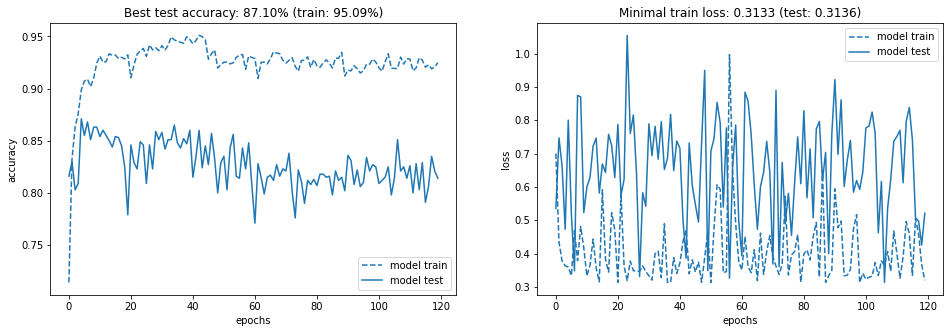

In [ ]:
show_results(model=logs)

In [ ]:
torch.save(model.state_dict(), 'text_classifier_weights.pt')

#Summary

The model achieved the best accuracy on the test set equal to **87.1**.

What may improve performance of the model in the future, is training it on texts with decoded emojis and emotikons. They play important role in representing sentiment of a statement and can influence harmfulness of a tweet.

#Sources

http://2019.poleval.pl/index.php/tasks/task6

http://dsmodels.nlp.ipipan.waw.pl/

https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

https://developpaper.com/examples-of-text-classification-using-python-and-torch-text/
